In [7]:
#Questions
# - dense layer?
# - model doing better with less layers?
# - tuning layers
# - construct a class to test model differences
# - visualize model flow?
# - visualize filter outputs?
# - modeling doing better during validation than training?

In [202]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from collections import Counter
import time
import random

import tensorflow as tf
from keras.datasets import mnist, fashion_mnist
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam

### Data Exploration

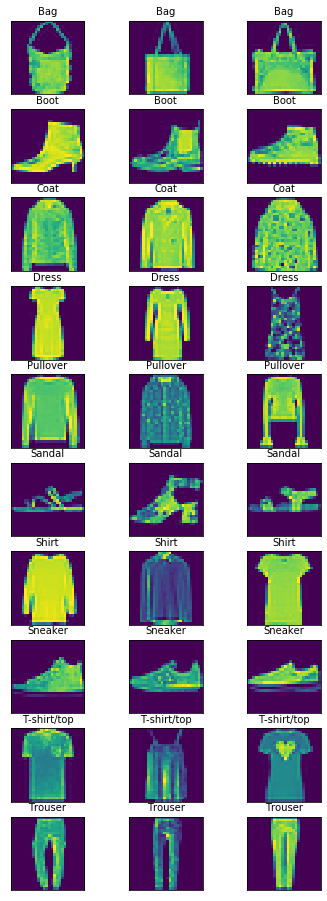

In [3]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

categories = {0: 'T-shirt/top',
             1: 'Trouser',
             2: 'Pullover',
             3: 'Dress',
             4: 'Coat',
             5: 'Sandal',
             6: 'Shirt',
             7: 'Sneaker',
             8: 'Bag',
             9: 'Boot'}

#plot sample of categories
test = list(zip(x_train, [categories[x] for x in y_train]))
test_df = pd.DataFrame(test)

function = lambda obj: obj.loc[np.random.choice(obj.index, 3, False)]
grouped = test_df.groupby(1).apply(function)

fig, axes = plt.subplots(10,3, figsize = (6,16))
axes = axes.flatten()
for i, image in enumerate(grouped[0]):
    axes[i].imshow(image)
    axes[i].set_title(grouped[1][i], size=10)
    axes[i].set_xticks([])
    axes[i].set_yticks([])

### Data Processing and CNN

In [4]:
#scaling to ease computational burden of model
#note: scaling does not change the way the image renders
x_train_scaled = x_train/255
x_test_scaled = x_test/255

#convert to float 32 to use less space, float64 uses twice as much memory
x_train_scaled_32 = x_train_scaled.astype('float32')
x_test_scaled_32 = x_test_scaled.astype('float32')

#reshape to 4d array with expected input shape of (batch, rows, columns, channels)
x_train_scaled_shape = x_train_scaled_32.reshape(x_train_scaled_32.shape[0], 28, 28, 1)
x_test_scaled_shape = x_test_scaled_32.reshape(x_test_scaled_32.shape[0], 28, 28, 1)

#convert labels to one-hot-encoded arrays
y_train_cat = to_categorical(y_train, 10)
y_test_cat = to_categorical(y_test, 10)

In [236]:
class CNN:
    """Takes in a model and returns model results"""
    def __init__(self, model_list):
        self.model_list = model_list
        
    def model_test(self, test_metric, test_val):
        model_list = self.model_list
        epochs=5
        start_time = time.time()
        model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
        end_time = time.time()
        model_time = end_time - start_time

        model_output=model.fit(x_train_scaled_shape, y_train_cat, batch_size=100, epochs=epochs, verbose=1, 
                         shuffle=True, validation_split=0.2)
        history = pd.DataFrame(model_output.history)
        history['epoch'] = list(range(1, epochs+1))
        history['model_time'] = model_time
        history['metric'] = test_metric
        history['test_val'] = str(test_val)
        return history
    
#when just a tuple, the len of kernels is 2
#when a list of a single tuple, the second model doesn't work
def model_list(kernels=[(5,5)], filters=10, layers = 'simple'):
    """function to create list of sequential models
    pass in list of tuples for kernel size, or list of scalars for number of filters"""
    if len(kernels) > 1:
        models=[]
        metric='kernels'
        for kernel in kernels:
            model = Sequential([Conv2D(filters=filters, kernel_size=kernel, activation='relu',input_shape=x_train_scaled_shape.shape[1:]),
                              Flatten(),
                              Dense(10, activation='softmax')])
            models.append((model, kernel, 'kernel'))
        return models
            
    if len(filters) > 1:
        models=[]
        metric='filters'
        for filter_val in filters:
            model = Sequential([Conv2D(filters=filter_val, kernel_size=kernels[0], activation='relu', input_shape=x_train_scaled_shape.shape[1:]),
                              Flatten(),
                              Dense(10, activation='softmax')])
            models.append((model, filter_val, 'filters'))
        return models

In [237]:
kernel_models = model_list(kernels=[(3,3),(5,5),(10,10),(28,28)])
filter_models = model_list(filters=(5,10,30,60))
models = kernel_models + filter_models
    
model_output = pd.DataFrame()
for model_values in models:
    model = model_values[0]
    test_val = model_values[1]
    test_metric = model_values[2]
    cnn = CNN(model)
    results = cnn.model_test(test_metric, test_val)
    model_output = model_output.append(results)

Train on 48000 samples, validate on 12000 samples
Epoch 1/5
48000/48000 [==============================] - 3s 56us/step - loss: 0.5319 - accuracy: 0.8155 - val_loss: 0.3878 - val_accuracy: 0.8659
Epoch 2/5
48000/48000 [==============================] - 3s 56us/step - loss: 0.3606 - accuracy: 0.8751 - val_loss: 0.3419 - val_accuracy: 0.8800
Epoch 3/5
48000/48000 [==============================] - 3s 63us/step - loss: 0.3196 - accuracy: 0.8880 - val_loss: 0.3344 - val_accuracy: 0.8790
Epoch 4/5
48000/48000 [==============================] - 3s 62us/step - loss: 0.2908 - accuracy: 0.8979 - val_loss: 0.3071 - val_accuracy: 0.8909
Epoch 5/5
48000/48000 [==============================] - 3s 58us/step - loss: 0.2745 - accuracy: 0.9023 - val_loss: 0.3080 - val_accuracy: 0.8891
Train on 48000 samples, validate on 12000 samples
Epoch 1/5
48000/48000 [==============================] - 4s 92us/step - loss: 0.5280 - accuracy: 0.8185 - val_loss: 0.4013 - val_accuracy: 0.8629
Epoch 2/5
48000/48000 [=

In [245]:
model_output

,val_loss,val_accuracy,loss,accuracy,epoch,model_time,metric,test_val
0,0.387791,0.865917,0.531890,0.815521,1,0.024402,kernel,"(3, 3)"
1,0.341894,0.880000,0.360595,0.875125,2,0.024402,kernel,"(3, 3)"
2,0.334369,0.879000,0.319581,0.888000,3,0.024402,kernel,"(3, 3)"
3,0.307133,0.890917,0.290794,0.897854,4,0.024402,kernel,"(3, 3)"
4,0.307995,0.889083,0.274510,0.902313,5,0.024402,kernel,"(3, 3)"
0,0.401313,0.862917,0.528029,0.818542,1,0.030918,kernel,"(5, 5)"
1,0.355058,0.875667,0.357421,0.874500,2,0.030918,kernel,"(5, 5)"
2,0.352811,0.873083,0.319854,0.888229,3,0.030918,kernel,"(5, 5)"
3,0.333375,0.882583,0.297455,0.896208,4,0.030918,kernel,"(5, 5)"
4,0.311614,0.889000,0.280282,0.901854,5,0.030918,kernel,"(5, 5)"


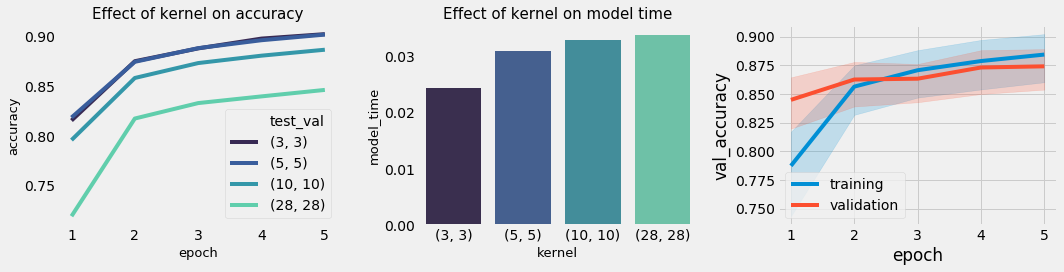

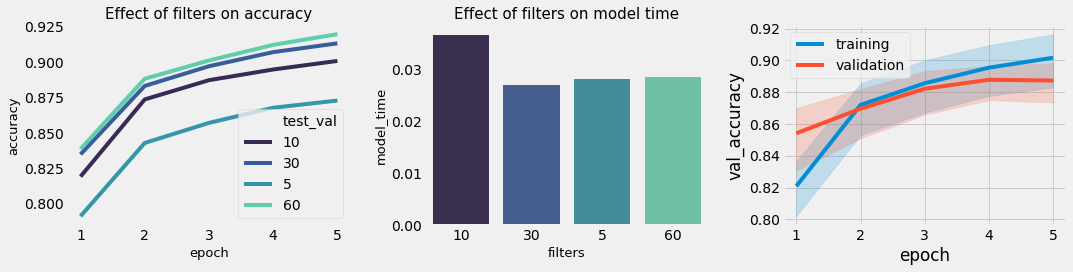

In [251]:
for metric in ['kernel','filters']:
    metric_results = model_output[model_output['metric']==metric]

    fig, axes = plt.subplots(1,3,figsize=(15,4))
    axes = axes.flatten()

    palette_size = len(kernel_results['test_val'].unique())
    plt.style.use('fivethirtyeight')
    sns.lineplot(metric_results['epoch'], metric_results['accuracy'], hue=metric_results['test_val'],
                palette=sns.color_palette("mako", palette_size),ax = axes[0])
    axes[0].set_title('Effect of '+ metric +' on accuracy',size=15)
    axes[0].set_xlabel('epoch',size=13)
    axes[0].set_ylabel('accuracy', size=13)
    axes[0].grid(False)

    sns.barplot(metric_results['test_val'], metric_results['model_time'], palette='mako', ax=axes[1])
    axes[1].set_title('Effect of '+ metric +' on model time',size=15)
    axes[1].set_xlabel(metric,size=13)
    axes[1].set_ylabel('model_time', size=13)
    axes[1].grid(False)
    
    sns.lineplot(metric_results['epoch'],metric_results['accuracy'], ax=axes[2], label='training')
    sns.lineplot(metric_results['epoch'], metric_results['val_accuracy'], ax=axes[2], label='validation')
    axes[2].legend()
    plt.tight_layout()

In [146]:
def create_records(d: dict) -> list:
    (key1, val1), (key2, val2) = d.items()
    if isinstance(val2, list):
        key1, val1, key2, val2 = key2, val2, key1, val1
    return [{key2: val2, key1: x} for x in val1]

In [198]:
mydicts = create_records({'test1':(5,5), 'test2':[6,7,8]})

In [201]:
for dictionary in mydicts:
    print(dictionary['test1'])

(5, 5)
(5, 5)
(5, 5)


In [5]:
# if len(kernel) > 1:
#     for kernel in kernels:
#         model = sequential(filters=filter_value, kernels=kernels)
        
# if len(filters) > 1:
#     for filter_value in filters:
#         model = 

# models = [model1, model2]
# for model in models:
#     current_model = CNN(model)
    

# class CNN:
#     def __init__(self, **kwargs):
#         self.metric_values = kwargs 
#         self.metric = list(kwargs)[0]
#         self.test_values = list(kwargs.values())[0]
#         self.kernel = (5,5)
        
#     def get_model(self, filter_value=5, kernel_value=(5,5)):
# #         initial_model = Sequential([Conv2D(filters=filter_value, kernel_size=kernel_value, activation='relu', input_shape=x_train_scaled_shape.shape[1:]),
# #                             Flatten(),
# #                            Dense(10, activation='softmax')])
# #         return initial_model
#             models = []
#             for value in test_values:
#                     create model
            
    
#     def model_test(self):
#         metric_values = self.metric_values
#         test_values = metric_values.values()
#         models=[]
#         model_results=pd.DataFrame()
#         for value in list(*test_values): 
#             model_test = self.get_model(kernel_value=value)
            
#             model_test.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
            
#             #calculate time per model, fit model
#             start_time = time.time()
#             epochs=3
#             results = model_kernel.fit(x_train_scaled_shape, y_train_cat, batch_size=100, epochs=epochs, verbose=1, validation_split=0.2)
#             end_time = time.time()
#             model_time = end_time-start_time

#             #append model history to results_kernel dataframe
#             history = pd.DataFrame(results.history)
#             history['test'] = list(metric_values)[0]
#             history['test_value'] = str(value)
#             history['model_time'] = model_time
#             history['epoch'] = list(range(1,epochs+1))
#             model_results = model_results.append(history)
#         return model_results
    
# mycnn = CNN(kernel=[(3,3),(5,5),(10,10),(28,28)])
# mycnn.metric_values
# model_results = mycnn.model_test()

# # datagen = ImageDataGenerator(rotation_range=10,
# #                             zoom_range=0.1,
# #                             width_shift_range=0.1,
# #                             height_shift_range=0.1)

# # epochs = 3
# # batch_size = 100
# # history = model_kernel.fit_generator(datagen.flow(x_train_sample, y_train_sample, batch_size=batch_size), epochs=epochs,
# #                              validation_data=(x_test_sample, y_test_sample), steps_per_epoch=x_train_sample.shape[0//batch_size])


In [22]:
# datagen = ImageDataGenerator(rotation_range=10,
#                             zoom_range=0.1,
#                             width_shift_range=0.1,
#                             height_shift_range=0.1)

# epochs = 3
# batch_size = 100
# history = model.fit_generator(datagen.flow(x_train_sample, y_train_sample, batch_size=batch_size), epochs=epochs,
#                              validation_data=(x_test_sample, y_test_sample), steps_per_epoch=x_train_sample.shape[0//batch_size])


### Prediction analysis

In [24]:
#calculate predictions
predictions = model_kernel.predict(x_test_sample)

counts=Counter()
for x,y in zip(predictions, y_test):
    if np.argmax(x)==y:
        counts[y] +=1
        
counts

Counter({9: 956,
         2: 740,
         1: 977,
         6: 687,
         4: 916,
         5: 959,
         7: 962,
         3: 863,
         8: 970,
         0: 865})

In [37]:
#compare predicted to actuals
pred_labels = [np.argmax(x) for x in predictions]
pred_actual = pd.DataFrame(zip(y_test, pred_labels)).rename(columns={0:'actual', 1:'predicted'})
pred_actual['actual_label'] = pred_actual['actual'].map(categories)
pred_actual['predicted_label'] = pred_actual['predicted'].map(categories)
pred_actual['correct'] = pred_actual['actual'] == pred_actual['predicted']
pred_actual

pred_actual.groupby('actual_label')['correct'].aggregate({'sum':sum, 'total':len})

/Users/christinejiang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version. Use                 named aggregation instead.

    >>> grouper.agg(name_1=func_1, name_2=func_2)

  if __name__ == '__main__':


,sum,total
actual_label,,
Bag,970.0,1000
Boot,956.0,1000
Coat,916.0,1000
Dress,863.0,1000
Pullover,740.0,1000
Sandal,959.0,1000
Shirt,687.0,1000
Sneaker,962.0,1000
T-shirt/top,865.0,1000


In [94]:
test = incorrect.groupby(['actual_label','predicted_label'])['actual'].count().sort_values(ascending=False).to_frame()
test = test.reset_index()
test['labels'] = test['actual_label'] + '_'+ test['predicted_label']
test.head()

,actual_label,predicted_label,actual,labels
0,Pullover,Coat,147,Pullover_Coat
1,Shirt,T-shirt/top,134,Shirt_T-shirt/top
2,Shirt,Coat,106,Shirt_Coat
3,T-shirt/top,Shirt,96,T-shirt/top_Shirt
4,Pullover,Shirt,78,Pullover_Shirt


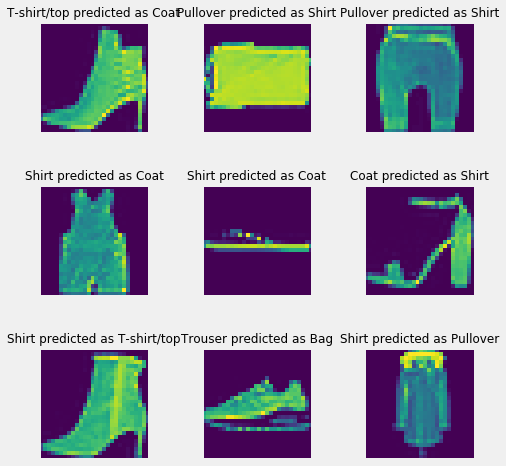

In [100]:
#closer look at shirts, most incorrectly predicted label
#something is very wrong with these labels lol
incorrect = pred_actual[pred_actual['actual_label']!=pred_actual['predicted_label']]
incorrect_indices = incorrect.index

sampling_incorrect = random.choices(incorrect_indices, k=9)
fig, axes = plt.subplots(3,3,figsize=(7,7))
axes = axes.flatten()

for i,index in enumerate(sampling_incorrect):
    actual_label = pred_actual.iloc[index]['actual_label']
    predicted_label = pred_actual.iloc[index]['predicted_label']
    axes[i].imshow(x_train_scaled[index])
    axes[i].set_title(actual_label +' predicted as '+predicted_label, size=12)
    axes[i].grid(False)
    axes[i].set_xticks([])
    axes[i].set_yticks([])
plt.tight_layout()

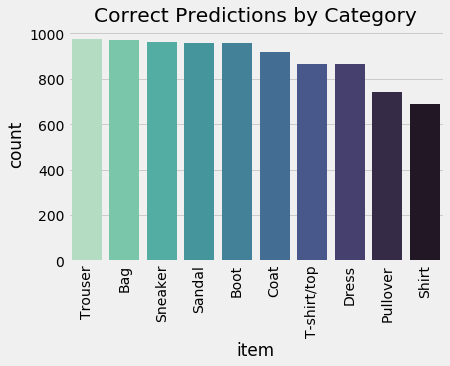

In [29]:
#plot frequency of accurate predictions by category
predicted = pd.DataFrame.from_dict(counts, orient='index').reset_index().rename(columns={'index':'label', 0:'count'})
predicted['item'] = predicted['label'].map(categories)
predicted = predicted.sort_values('count', ascending=False)
sns.barplot(predicted['item'], predicted['count'], palette='mako_r')
plt.title('Correct Predictions by Category')
ticks=plt.xticks(rotation='vertical')

In [30]:
#save and load a model
model.save('mnist_fashion.model')
new_model = tf.keras.models.load_model('mnist_fashion.model')